In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import os
from pathlib import Path
import json

import sys

sys.path.append("scripts")

import utils
import distclassipy as dcpy

cd = dcpy.Distance()

In [2]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
np.random.seed(settings_dict["seed_choice"])

classification_letter = "c"
classification_problem = settings_dict["classification_problem"][classification_letter]
classes_to_keep = settings_dict["classes_to_keep"][classification_letter]
results_subfolder = f"{classification_letter}. {classification_problem}"
sns_dict = settings_dict["sns_dict"]

sns.set_theme(**sns_dict)

In [3]:
check_estimator(dcpy.DistanceMetricClassifier())  # passes

In [4]:
# Load Data
X_df_FULL = pd.read_csv("data/X_df.csv", index_col=0)
y_df_FULL = pd.read_csv("data/y_df.csv", index_col=0)

In [5]:
y_df_FULL["class"].value_counts()

class
SR       558
DSCT     558
CEP      558
EW       558
RR       558
RSCVN    558
BYDra    558
RRc      558
Mira     558
EA       558
Name: count, dtype: int64

In [6]:
# Remove manually selected 'bad' features
with open(os.path.join("results", results_subfolder, "drop_features.txt")) as f:
    bad_features = json.load(f)  # manually selected

X_df_FULL = X_df_FULL.drop(bad_features, axis=1)

print(X_df_FULL.shape[1])

31


In [7]:
# Keep only current classes
cl_keep_str = "_".join(classes_to_keep)

y_df = y_df_FULL[y_df_FULL["class"].isin(classes_to_keep)]
X_df = X_df_FULL.loc[y_df.index]
X = X_df.to_numpy()
y = y_df.to_numpy().ravel()

In [8]:
feats_top_plot = 15
### For plotting only - how many features to plot in relative importance

### Distance Based

In [9]:
all_metrics = [
    "euclidean",
    "braycurtis",
    "canberra",
    "cityblock",
    "chebyshev",
    cd.clark,
    "correlation",
    "cosine",
    cd.hellinger,
    cd.jaccard,
    cd.lorentzian,
    cd.marylandbridge,
    cd.meehl,
    cd.motyka,
    cd.soergel,
    cd.wave_hedges,
    cd.kulczynski,
    cd.add_chisq,
]

scoring = "f1_macro"
feats_to_keep = X_df_FULL.columns

In [10]:
allns = []
all_selected_scores = []
all_metric_strs = []

Metric:   0%|          | 0/2 [00:00<?, ?it/s]

******************** Euclidean ********************


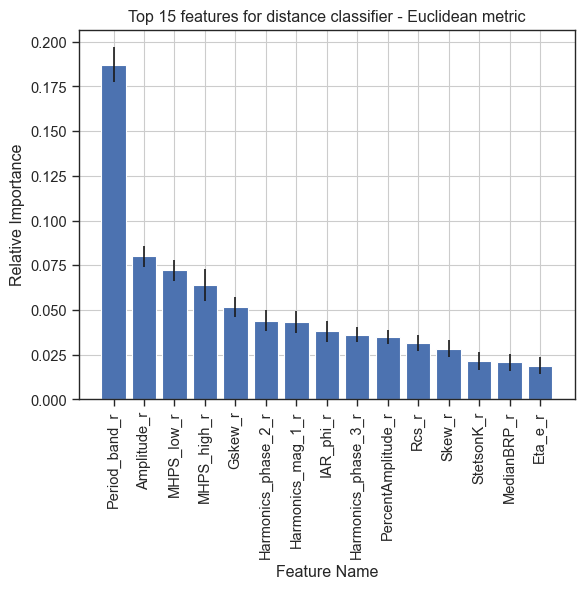

ValueError: when `importance_getter=='auto'`, the underlying estimator DistanceMetricClassifier should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

F1 = 91.88 %
Accuracy = 91.85 %
Matthew's Coefficient = 89.14 %


In [11]:
for metric in tqdm(all_metrics[:2], desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    locpath = os.path.join("results", results_subfolder, "distclassipy", metric_str)
    print("*" * 20, metric_str, "*" * 20)
    Path(locpath).mkdir(parents=True, exist_ok=True)

    # Feature Importance via Feature Permutation

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, stratify=y
    )

    lcdc = dcpy.DistanceMetricClassifier(
        metric=metric, scale_std=True, calculate_kde=False, calculate_1d_dist=False
    )
    lcdc.fit(X_train, y_train)

    imp_vals, imp_all = feature_importance_permutation(
        predict_method=lcdc.predict,
        X=X_test,
        y=y_test,
        metric="accuracy",
        num_rounds=10,
        seed=settings_dict["seed_choice"],
    )

    std = np.std(imp_all, axis=1)
    indices = np.argsort(imp_vals)[::-1]

    x_ax = range(X.shape[1])
    y_ax = imp_vals[indices]
    yerr = std[indices]
    featnames = X_df.columns[indices]

    fig, ax = plt.subplots()
    ax.bar(x_ax[:feats_top_plot], y_ax[:feats_top_plot], yerr=yerr[:feats_top_plot])
    ax.set_title(
        f"Top {feats_top_plot} features for distance classifier - {metric_str.title()} metric"
    )
    ax.set_xticks(x_ax[:feats_top_plot], featnames[:feats_top_plot], rotation=90)
    ax.set_xlabel("Feature Name")
    ax.set_ylabel("Relative Importance")

    # ax.set_xlim([-1, X.shape[1]])
    # plt.savefig(f"{locpath}/feature_importance.pdf", bbox_inches="tight")
    plt.show()

    featimp_df = pd.DataFrame(
        data=y_ax, index=featnames, columns=["Relative Importance"]
    )
    featimp_df.index.name = "Feature Name"
    # featimp_df.to_csv(f"{locpath}/feature_importance.csv")

    # Sequential Feature Selection 1-31 features

    lcdc = dcpy.DistanceMetricClassifier(
        metric=metric, scale_std=True, calculate_kde=False, calculate_1d_dist=False
    )


    n_features_to_select = 10

    rfe = RFE(
        estimator=lcdc,
        n_features_to_select=n_features_to_select,
        step=1,
        verbose=0,
    ).fit(X_df.loc[:, feats_to_keep], y)

    # Generating a mask of selected features
    selected_features_mask = rfe.support_
    selected_features = X_df.columns[selected_features_mask]

    # Creating a DataFrame to display selected features and their rankings
    selected_features_df = pd.DataFrame(
        {
            "Feature Name": X_df.columns,
            "Selected": selected_features_mask,
            "Ranking": rfe.ranking_,
        }
    )
    selected_features_df = selected_features_df.sort_values(by="Ranking")
    selected_features_df.to_csv(f"{locpath}/rfe_selected_features.csv")

    # Plotting the selected features (if needed, adjust or remove plotting as per requirements)
    fig, ax = plt.subplots()
    selected_features_df[selected_features_df["Selected"]].plot(
        kind="barh", x="Feature Name", y="Ranking", ax=ax, color=sns.color_palette()[0]
    )
    ax.set_title("Selected Features by RFE")
    plt.savefig(f"{locpath}/rfe_selected_features_plot.pdf", bbox_inches="tight")
    plt.show()

    # # Reloading to
    # sfs_df = pd.read_csv(f"{locpath}/sfs_allfeatures.csv", index_col=0)
    # feats_idx, feats = utils.load_best_features(sfs_df)

    # print(f"{metric_str}: Selected {len(feats)} features: {feats}")
    # plt.axvline(x=len(feats), color=sns.color_palette()[3], label="Selected features")
    # # plt.legend()
    # plt.savefig(f"{locpath}/sfs_allfeatures_plot_marked.pdf", bbox_inches="tight")
    # plt.show()

    # # Using the Selected Feature Subset For Making New Predictions

    # # Cross validation
    # lcdc = dcpy.DistanceMetricClassifier(
    #     metric=metric, scale_std=True, calculate_kde=False, calculate_1d_dist=False
    # )
    # X_sfs = X[:, feats_idx]
    # y_pred = cross_val_predict(lcdc, X_sfs, y, cv=5, n_jobs=-1)

    # acc = accuracy_score(y, y_pred)
    # f1score = f1_score(y, y_pred, average="macro")
    # matthew_coef = matthews_corrcoef(y, y_pred)

    # ax = utils.plot_cm(y_true=y, y_pred=y_pred)
    # ax.set_title(f"{metric_str.title()} metric")
    # plt.savefig(f"{locpath}/sfs_best_confusion_matrix.pdf", bbox_inches="tight")
    # plt.show()

    # dat = np.hstack([y_pred.reshape(-1, 1), y.reshape(-1, 1)])
    # objs = X_df.index
    # preds_best_df = pd.DataFrame(data=dat, columns=["y_pred", "y_true"], index=objs)
    # preds_best_df.to_csv(f"{locpath}/preds_best.csv")

    # print(
    #     f"F1 = {f1score*100:.2f} %\nAccuracy = {acc*100:.2f} %\nMatthew's Coefficient = {matthew_coef*100:.2f} %"
    # )

    # ## new
    # allns.append(len(feats))
    # all_selected_scores.append(f1score)
    # all_metric_strs.append(metric_str)

    # # Confidence calculation

    # lcdc = dcpy.DistanceMetricClassifier(
    #     metric=metric, scale_std=True, calculate_kde=True, calculate_1d_dist=True
    # )

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X_sfs, y, test_size=0.33, random_state=settings_dict["seed_choice"]
    # )

    # lcdc.fit(X_train, y_train)

    # y_pred_test = lcdc.predict_and_analyse(X_test)
    # y_testdf = pd.DataFrame(data=y_test, columns=["class"])
    # y_testdf["pred"] = y_pred_test
    # y_testdf.to_csv(f"{locpath}/testpreds_class.csv")

    # lcdc.df_canonical_.to_csv(f"{locpath}/df_canonical.csv")
    # lcdc.canonical_dist_df_.to_csv(f"{locpath}/canonical_dist_df.csv")
    # lcdc.df_std_.to_csv(f"{locpath}/df_std.csv")

    # lcdc.calculate_confidence(method="distance_inverse")
    # lcdc.confidence_df_.to_csv(f"{locpath}/distance_inverse_confidence.csv")

    # lcdc.calculate_confidence(method="kde_likelihood")
    # lcdc.confidence_df_.to_csv(f"{locpath}/kde_likelihood_confidence.csv")

    # lcdc.calculate_confidence(method="1d_distance_inverse")
    # lcdc.confidence_df_.to_csv(f"{locpath}/1d_distance_inverse_confidence.csv")

In [12]:
summaryqdf = pd.DataFrame(
    data=np.array([allns, all_selected_scores]).T,
    index=all_metric_strs,
    columns=["Number of selected features", "Selected F1 Score"],
)
summaryqdf.to_csv(
    os.path.join(
        "results", results_subfolder, "distclassipy", "summary_scores_q1q5.csv"
    )
)
summaryqdf

,Number of selected features,Selected F1 Score
Euclidean,4.0,0.800426
Braycurtis,4.0,0.904295
Canberra,3.0,0.912266
Cityblock,4.0,0.849936
Chebyshev,4.0,0.764234
Clark,6.0,0.919913
Correlation,20.0,0.809610
Cosine,10.0,0.840039
Hellinger,2.0,0.917967
Jaccard,1.0,0.889726


In [13]:
summaryqdf.describe()

,Number of selected features,Selected F1 Score
count,18.000000,18.000000
mean,5.888889,0.864398
std,4.921608,0.057577
min,1.000000,0.746742
25%,4.000000,0.817218
50%,4.000000,0.897011
75%,6.750000,0.906195
max,20.000000,0.919913
